First, we load up some useful libraries for visualization and data structures.

In [29]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.axes as axes
import copy
import random
from queue import PriorityQueue

Next we need a Maze class for pathfinding. It will help to have read the RedBlobGames [A\* tutorial](http://www.redblobgames.com/pathfinding/a-star/introduction.html) before continuing.

These Mazes are defined in ASCII diagrams and can have walls ("#"), empty spaces ("."), switches (numbers), and doors (letters; closed are uppercase). The "0" switch toggles the open status of all the "a" doors, "1" goes to the "b" doors, etc. Mazes can also contain pits: "?" pits have a 30% chance of killing the player and "!" pits have a 60% chance. Every maze has one player start location "@" and one goal square "X". Walls and closed doors block movement.

[(1, 0), (0, -1), (0, 1), 'switch']


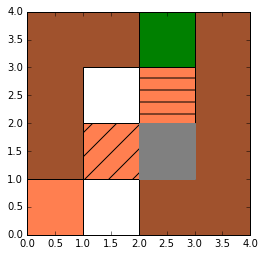

In [30]:
class Maze:
    SwitchMap = {"0":"a", "1":"b", "2":"c", "3":"d", "4":"e", "5":"f", "6":"g", "7":"h", "8":"i", "9":"j"}
    Colors = {"a":"coral","b":"tan","c":"palegreen","d":"blue","e":"cyan","f":"magenta","g":"yellow","h":"olive","i":"purple","j":"darkgreen",
              "0":"coral","1":"tan","2":"palegreen","3":"blue","4":"cyan","5":"magenta","6":"yellow","7":"olive","8":"purple","9":"darkgreen",
             "?":"orange",
             "!":"red",
             "x":"green","@":"gray",
             "#":"sienna",".":"white"}
    
    def __init__(self,rows):
        self.grid = [list(r) for r in rows]
        self.grid.reverse()
        
        # additional variables
        self.cost = 0
        
        height = len(self.grid)
        width = len(self.grid[0])
        self.exit_pos = None
        self.player_pos = None
        self.player_alive = True
        for y in range(0,height):
            assert len(self.grid[y]) == width, "All rows must be equal length!"
            for x in range(0,width):
                c = self.grid[y][x]
                assert c == "#" or c == "." or c == "!" or c == "?" or c == "@" or c.isalnum()
                if c.lower() == "x":
                    assert self.exit_pos == None
                    self.exit_pos = (x,y)
                if c == "@":
                    assert self.player_pos == None
                    self.player_pos = (x,y)
                    self.grid[y][x] = "."
    
    def clone(self):
        return copy.deepcopy(self)
    
    def toggle_cell(self,switchnum,c):
        if c.isalpha() and Maze.SwitchMap[switchnum] == c.lower():
            if c.islower():
                return c.upper()
            else:
                return c.lower()
        return c
    
    def toggle(self):
        assert self.player_alive
        height = len(self.grid)
        width = len(self.grid[0])
        (px,py) = self.player_pos
        switchnum = self.grid[py][px]
        assert switchnum.isnumeric()
        for y in range(0,height):
            for x in range(0,width):
                self.grid[y][x] = self.toggle_cell(switchnum,self.grid[y][x])
    
    def is_free(self,x,y):
        if y < 0 or y >= len(self.grid):
            return False
        if x < 0 or x >= len(self.grid[0]):
            return False
        cell = self.grid[y][x]
        return (
            cell == "." or cell == "X" or
            cell == "?" or cell == "!" or 
            (cell.isalpha() and cell.islower()) or cell.isnumeric()
        )
    
    def __eq__(self, other):
        return self.grid == other.grid and self.player_pos == other.player_pos and self.player_alive == other.player_alive
    def __neq__(self, other):
        return not self == other
    def __hash__(self):
        return hash(str(self.grid)) % 100000 + hash(self.player_pos) % 100000 + hash(self.player_alive) % 100000
    def __lt__(self, other):
        if self == other: return False
        return id(self) < id(other)
    
    def move_player(self,dx,dy):
        assert self.player_alive
        assert abs(dx)+abs(dy) == 1
        (x,y) = self.player_pos
        (newx,newy) = (x+dx,y+dy)
        assert self.is_free(newx,newy)
        self.player_pos = (x+dx,y+dy)
        cell = self.grid[y+dy][x+dx]
        if cell == "?" and random.random() < 0.3:
            self.player_alive = False
        if cell == "!" and random.random() < 0.6:
            self.player_alive = False
    
    def available_moves(self):
        if not self.player_alive:
            return []
        (x,y) = self.player_pos
        can_switch = self.grid[y][x].isnumeric()
        return [(dx,dy) for (dx,dy) in [(-1,0),(1,0),(0,-1),(0,1)] if self.is_free(x+dx,y+dy)] + (
            ["switch"] if can_switch else []
        )
    
    def is_at_exit(self):
        return self.player_alive and self.player_pos == self.exit_pos
    
    def draw(self):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(1,1,1, aspect='equal')
        ax1.set_axis_bgcolor('sienna')
        height = len(self.grid)
        width = len(self.grid[0])
        ax1.set_xlim([0,width])
        ax1.set_ylim([0,height])
        for y in range(0,height):
            for x in range(0,width):
                cell = self.grid[y][x]
                if cell == "#": continue
                is_door = cell.isalpha() and cell.lower() != "x"
                is_pit = cell == "?" or cell == "!"
                is_open = is_door and cell.islower()
                is_switch = cell.isnumeric()
                ax1.add_patch(
                    patches.Rectangle((x, y),
                                      1,1,
                                      fill=True,
                                      facecolor=Maze.Colors[cell.lower()],
                                      edgecolor="black",
                                      hatch="/" if is_switch else ("-" if (is_door and not is_open) else None),
                                      label=cell)
                )
        ax1.add_patch(
            patches.Rectangle(self.player_pos,
                              1,1,
                              fill=True,
                              hatch="x" if not self.player_alive else None,
                              facecolor=Maze.Colors["@"] if self.player_alive else "black",
                              edgecolor=Maze.Colors["@"] if self.player_alive else "white")
        )
        plt.show(fig1)
        
    def update_move(self,path):
        for pos in path:
            self.grid[pos[1]][pos[0]] = "g"

sample=Maze([
        "##X#",
        "#.A#",
        "#0?#",
        "a@##"
    ])
sample.move_player(0,1)
print(sample.available_moves())
sample.move_player(1,0)
sample.draw()

sample2 = Maze([
        "##X#",
        "#.A#",
        "#0?#",
        "a@##"
    ])


# Assignment 1

Write a function to solve pathfinding and switch-and-door puzzles with one of the heuristic search algorithms described during the lecture. Try it on the provided sample puzzles; if a puzzle gives your algorithm trouble, try to explain why that happens. Make sure the path you're getting is the actual shortest path!

Try to get this assignment done by Friday; the other two may take a little longer but the sooner you attempt them the earlier you can get feedback!

You may also try visualizing paths through the maze, implementing several different heuristic searches, comparing against aheuristic search, etc.

Generating mazes automatically would also be a great exercise!

In [31]:
def manhattan(goal, current):
    (x1, y1) = goal
    (x2, y2) = current
    return abs(x1-x2) + abs(y1-y2)

def heuristic(maze):
    # Return a path which solves the maze: a sequence of elements like (dx,dy) or "switch".
    # You can use maze.exit_pos and query maze.grid[row][column] to investigate the maze.
    path = [maze.player_pos]
    
    frontier = PriorityQueue()
    frontier.put((0, maze, path))
    
    mazes_used = {} # key is maze and value is maze previous to it
    mazes_used[maze] = None
    
    new_path = []
    
    while not frontier.empty():
        current = frontier.get()
        
        if not current[1].is_at_exit(): # if not at exit
            for m in current[1].available_moves():
                successor = current[1].clone()
                if m == "switch":
                    successor.toggle()
                    new_path = list(current[2])
                else:
                    (x,y) = m
                    successor.move_player(x,y)
                    next_pos = (current[1].player_pos[0] + m[0], current[1].player_pos[1] + m[1])
                    new_path = list(current[2]) + [next_pos]
                    successor.cost = current[1].cost + 1
                    
                if successor not in mazes_used or successor.cost < current[1].cost:
                    priority = successor.cost + manhattan(successor.exit_pos, successor.player_pos)
                    frontier.put((priority, successor, new_path))
                    mazes_used[successor] = current # current is the predecessor of successor
        else: # if reached exit
            current[2].pop()
            return current[2]
    return []

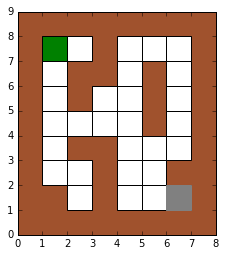

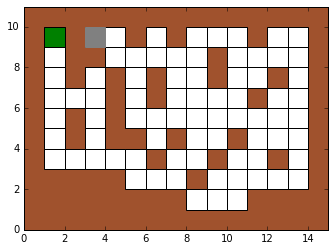

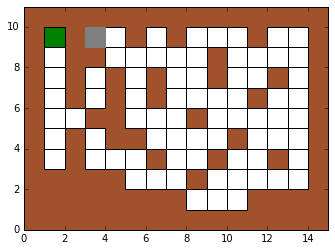

In [32]:
def maze1():
    return Maze([
        "########",
        "#X.#...#",
        "#.##.#.#",
        "#.#..#.#",
        "#....#.#",
        "#.##...#",
        "#..#..##",
        "##.#..@#",
        "########"
    ])

maze1().draw()

def maze2():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#...#.#....#..#",
        "#.#.#.........#",
        "#.#.##.#..#...#",
        "#.....#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze2().draw()

def mazeUnsolvable1():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#.#.#.#....#..#",
        "#..##...#.....#",
        "#.#.##....#...#",
        "#.#...#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

mazeUnsolvable1().draw()

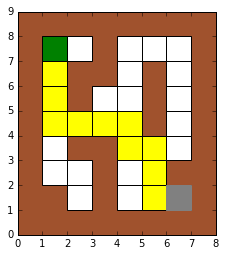

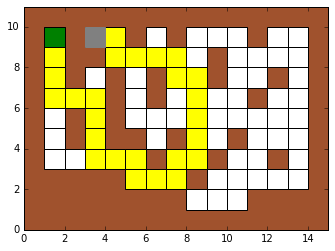

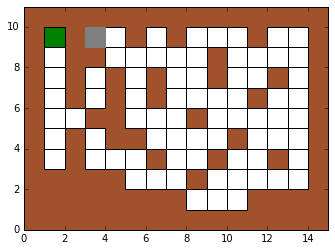

In [33]:
m1 = maze1()
m1.update_move(heuristic(m1))
m1.draw()

m2 = maze2()
m2.update_move(heuristic(m2))
m2.draw()

mu1 = mazeUnsolvable1()
mu1.update_move(heuristic(mu1))
mu1.draw()

You also have to be able to handle switch and door puzzles:

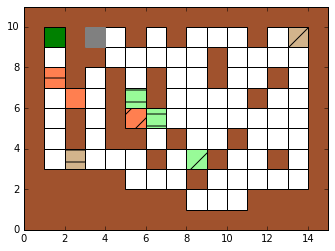

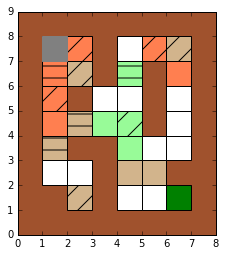

In [34]:
def maze3():
    return Maze([
        "###############",
        "#X#@.#.#...#.1#",
        "#.##.....#....#",
        "#A#.#.#..#..#.#",
        "#.a.#C#....#..#",
        "#.#.#0C.......#",
        "#.#.##.#..#...#",
        "#.B...#.2#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze3().draw()

def maze4():
    return Maze([
        "########",
        "#@0#.01#",
        "#A1#C#a#",
        "#0#..#.#",
        "#aBc2#.#",
        "#B##c..#",
        "#..#bb##",
        "##1#..X#",
        "########"
    ])

maze4().draw()

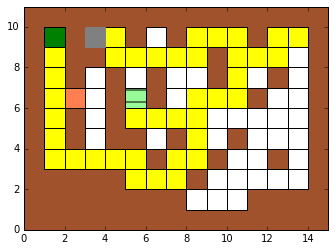

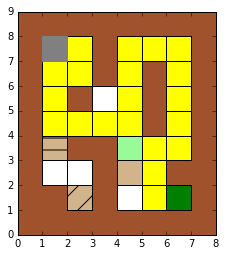

In [35]:
m3 = maze3()
m3.update_move(heuristic(m3))
m3.draw()

m4 = maze4()
m4.update_move(heuristic(m4))
m4.draw()

# Assignment 2

Once you have this working, write an agent which finds a policy for a "blind" puzzle using MCTS. "Blind" puzzles are just like the puzzles above, only (a) you don't get to see the whole puzzle or know the goal states in advance, and (b) some nodes are trap doors with a chance of dropping the player into a bottomless pit! Try different policies for deciding between exploit/explore and for doing rollouts and compare them.  Plot graphs on how learning improves with  more rollouts.

Of course, it should also be able to solve the earlier maze puzzles!

In [36]:
class TreeNode:
    
    def __init__(self, maze, action, val = 0):
        # instance variables: maze, action to get to the tree, expected value (to be updated),
        # parent, array of children, visit count
        self.maze = maze
        self.pos = pos
        self.expected_val = val
        self.action = None
        self.parent = None
        self.children = []
        self.unvisited_moves = self.maze.available_moves()
        self.visit_count = 0
        
        if self.maze.is_at_exit():
            self.reward = 1
        else: # if it's not the exit, there is no reward
            self.reward = 0
    
    def add_child(self, tree_node)
        self.children.append(tree_node)
        tree_node.parent = self
    
    def visit(self, r): # reward
        # visit count has been updated, this averages the expected value
        net_reward = self.expected_val * self.visit_count
        self.visit_count++
        new_reward = (net_reward + r)/self.visit_count
        
        # recursively calls
        r *= 0.999
        if (self.parent != None):
            self.parent.visit(r)
    
    def best_child(): # return chosen move based on UCT algorithm
        max_val = -1
        for move in self.maze.available_moves():
            copy = self.maze.clone()
            copy.move_player(move[0], move[1])
            # I don't understand why you don't need to make a copy of the maze. How else will you keep track of the actions?

            
            visits = child.visit_count
            if visits == 0: # if any have not been visited yet, it will automatically be chosen
                return child
            
            child_val = (child.expected_val/visits) + 2*0.707(Math.sqrt(2*ln(node.visit_count)/visits))
            if child_val > max_val:
                best_move = move
                max_val = child_val
        return best_move # return action

def tree_policy(node): # output is a node just added OR a terminal node
    # checks if the node is terminal
    if len(node.maze.available_moves()) == 0:
        return node
    
    # chooses which action out of the available moves to complete
    child = node.best_child()
    copy = child.maze.clone()
    if child.action == "switch":
        copy.toggle()
    else:
        copy.move_player(child[0], child[1])
    
    # finds one action to do
    for n in node.children:
        if n.maze == copy:
            return tree_policy(n) # recursive
    new_node = TreeNode(copy, child)
    node.add_child(new_node)
    return new_node

    # current_node = node
    # for i in range(0,100):
        # next_node = best_child(maze, current_node)

def default_policy(node, bound):
    # track number of steps
    # return (terminal_reward, num_steps)
    copy = node.maze.clone()
    steps = 0
    while (!copy.is_at_exit() || len(copy.available_moves()) == 0 ||
           !copy.is_alive || step < bound):
        poss_moves = copy.available_moves()
        randomMove = poss_moves[Math.rand(0, len(poss_moves))]
        copy.move(randomMove[0], randomMove[1])
        steps++
    if (copy.is_at_exit()):
        return (1, steps)
    return (0, steps)

def backpropagate(node, reward, num_steps):
    # while loop
    # reducing_factor gamma is 0.999999, to the power of num_steps * reward
    pass
    
    

        
def mcts(maze,iterations):
    # Return the expected value (a number between 0 for "player dead", 1 for "made it to the end")
    # for a budget of `iterations` rollouts.
    # Should also return the best found path (the one most likely to lead to success).
    # Here, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` rollouts, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)
    
    
    # 1. Initialize tree
    parent = TreeNode(maze,)
    # 2. Until out of time
    for i in range 0, iterations:
        child = tree_policy(maze, None, )
        
    # Pick a tree node T and action A using Tree Policy
    # Add S = successor(T, A)
    # Simulate from S until time/terminal node is reached (Track number of steps N, reward R)
    # Backup reward R to S, T, and T's ancestor

    return ([], 0)

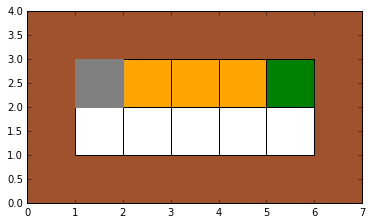

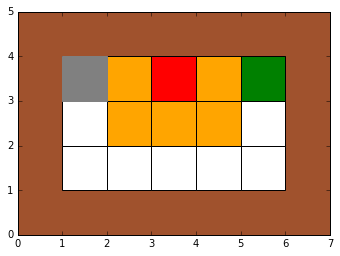

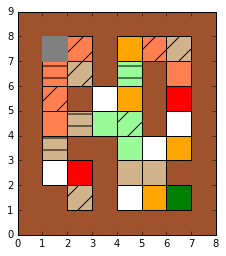

In [37]:
def maze5():
    return Maze([
        "#######",
        "#@???X#",
        "#.....#",
        "#######"
    ])

maze5().draw()

def maze6():
    return Maze([
        "#######",
        "#@?!?X#",
        "#.???.#",
        "#.....#",
        "#######"
    ])

maze6().draw()

def maze7():
    return Maze([
        "########",
        "#@0#?01#",
        "#A1#C#a#",
        "#0#.?#!#",
        "#aBc2#.#",
        "#B##c.?#",
        "#.!#bb##",
        "##1#.?X#",
        "########"
    ])

maze7().draw()

# Assignment 3

Do assignment 2 again, but with reinforcement learning! Compare various approaches and parameters (e.g.\ different discounting rates, Sarsa vs Q-learning, etc) against your MCTS agents in terms of iterations required to reach certain levels of performance. Plot graphs showing how learning improves with more iterations. Print or draw out (at least some of) the state-value or action-value matrix.

Read as much as you care to of Sutton & Barto---[section 2](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node39.html) is especially useful.


In [38]:
def rl(maze,iterations):
    # Return the best path (most likely to lead to success) along with its expected value and a validated value
    # for a budget of `iterations` experiments.
    # As above, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` experiments, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)

    return ([],0,0)

## Bonus Assignment

Make an adversary for the maze who is trying to eat the player. Try to get the best performing adversary possible!